#Assignment -3
#Sharmila Gowri Velugula - ku3936

#**3C) Seq2Seq Language translation Model - Word Level with Attention**

Import Marathi text file[mar.txt], attention.py file [For using attention mechanism]

The major drawback of encoder-decoder model in sequence to sequence recurrent neural network is that it can only work on short sequences. It is difficult for the encoder model to memorize long sequences and convert it into a fixed-length vector. Moreover, the decoder receives only one information that is the last encoder hidden state. Hence it's difficult for the decoder to summarize large input sequence at once

Now, this is where the concept of ‘Attention Mechanism’ comes. The major intuition about this is that it predicts the next word by concentrating on a few relevant parts of the sequence rather than looking on the entire sequence.

#Import Libraries

In [1]:
from attention import AttentionLayer

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np

#Load the Dataset

In [3]:
with open('mar.txt','r') as f:
  data = f.read()


#Data Cleaning

In [4]:

uncleaned_data_list = data.split('\n')
len(uncleaned_data_list)

40189

In [5]:

uncleaned_data_list = uncleaned_data_list[:38695]
len(uncleaned_data_list)

38695

In [6]:
english_word = []
marathi_word = []
cleaned_data_list = []
for word in uncleaned_data_list:
  english_word.append(word.split('\t')[:-1][0])
  marathi_word.append(word.split('\t')[:-1][1])

In [7]:
len(english_word), len(marathi_word)


(38695, 38695)

In [8]:
language_data = pd.DataFrame(columns=['English','Marathi'])
language_data['English'] = english_word
language_data['Marathi'] = marathi_word
language_data.to_csv('language_data.csv', index=False)
language_data = pd.read_csv('language_data.csv')

In [9]:
language_data.head()


,English,Marathi
0,Go.,जा.
1,Run!,पळ!
2,Run!,धाव!
3,Run!,पळा!
4,Run!,धावा!


#Text PreProcessing

In [10]:
english_text = language_data['English'].values
marathi_text = language_data['Marathi'].values

In [11]:
english_text[0], marathi_text[0]


('Go.', 'जा.')

In [12]:
len(english_text), len(marathi_text)


(38695, 38695)

In [13]:
english_text_ = [x.lower() for x in english_text]
marathi_text_ = [x.lower() for x in marathi_text]

In [14]:
english_text_ = [re.sub("'",'',x) for x in english_text_]
marathi_text_ = [re.sub("'",'',x) for x in marathi_text_]

In [15]:
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
english_text_ = remove_punc(english_text_)
marathi_text_ = remove_punc(marathi_text_)

In [16]:
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text

# removing the digits from the marathi sentances
marathi_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in marathi_text_]
marathi_text_ = [re.sub("[\u200d]","",x) for x in marathi_text_]

# removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
marathi_text_ = [x.strip() for x in marathi_text_]

In [17]:
# removing the starting and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
marathi_text_ = [x.strip() for x in marathi_text_]

Adding ‘start’ and ‘end’ tag to marathi sentence. This will help the decoder to know from where to start decoding and when to end.

In [18]:
# Putting the start and end words in the marathi sentances
marathi_text_ = ["start " + x + " end" for x in marathi_text_]

In [19]:
# manipulated_marathi_text_
marathi_text_[0], english_text_[0]

('start जा end', 'go')

In [20]:
# manipulated_marathi_text_
marathi_text_[0], english_text_[0]

('start जा end', 'go')

#Data Preparation: Train/Test Data Split

In [21]:

X = english_text_
Y = marathi_text_

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)
len(X_train),len(y_train), len(X_test), len(y_test)

(34825, 34825, 3870, 3870)

In [23]:

X_train[0], y_train[0]

('i was speaking to you', 'start मी तुझ्याशी बोलत होते end')

Determine the maximum length of our sentences in both English and Marathi.

In [24]:

def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

#Training data
max_length_english = Max_length(X_train)
max_length_marathi = Max_length(y_train)

#Test data
max_length_english_test = Max_length(X_test)
max_length_marathi_test = Max_length(y_test)

In [25]:
max_length_marathi, max_length_english


(14, 12)

### Tokenization

As a neural network requires numerical data to process, it becomes necessary to convert our string input to a numerical list. So we use Tokenizer provided by keras-preprocessing library. It is also important to have an equal length of all input sequences in sequence-to-sequence models. So, we will pad extra ‘0s’ to make the sequence of the same length. This would be done by pad_sequence.

In [26]:
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')

X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')


In [27]:
marathiTokenizer = Tokenizer()
marathiTokenizer.fit_on_texts(y_train)
Mword2index = marathiTokenizer.word_index
vocab_size_target = len(Mword2index) + 1

y_train = marathiTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_marathi, padding='post')

y_test = marathiTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_marathi, padding='post')


In [28]:
vocab_size_source, vocab_size_target

(4996, 11806)

To save our preprocessing time whenever we reuse it again in future, we will save our important attributes. So, we will do it with the help of pickle library.

In [29]:
with open('NMT_data.pkl','wb') as f:
  pkl.dump([X_train, y_train, X_test, y_test],f)


In [30]:
with open('NMT_Etokenizer.pkl','wb') as f:
  pkl.dump([vocab_size_source, Eword2index, englishTokenizer], f)

with open('NMT_Mtokenizer.pkl', 'wb') as f:
  pkl.dump([vocab_size_target, Mword2index, marathiTokenizer], f)

In [31]:
X_train[0], y_train[0]

(array([  1,  16, 701,   5,   3,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32),
 array([  1,   4, 482, 220,  67,   2,   0,   0,   0,   0,   0,   0,   0,
          0], dtype=int32))

In [32]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [33]:
X_train[0], y_train[0]

(array([  1,  16, 701,   5,   3,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32),
 array([  1,   4, 482, 220,  67,   2,   0,   0,   0,   0,   0,   0,   0,
          0], dtype=int32))

#Build the Model

Instead of a simple encoder-decoder architecture, we used Attention Mechanism. Keras does not officially support attention layer. So, we can either implement our own attention layer or use a third-party implementation. For now, we used a third party attention mechanism. we also uploaded 'attention.py' file to the local. This attention is an implementation of ‘Bahdanau Attention’ .

In [34]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_length_english,)) 
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 12, 500)      2498000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 12, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

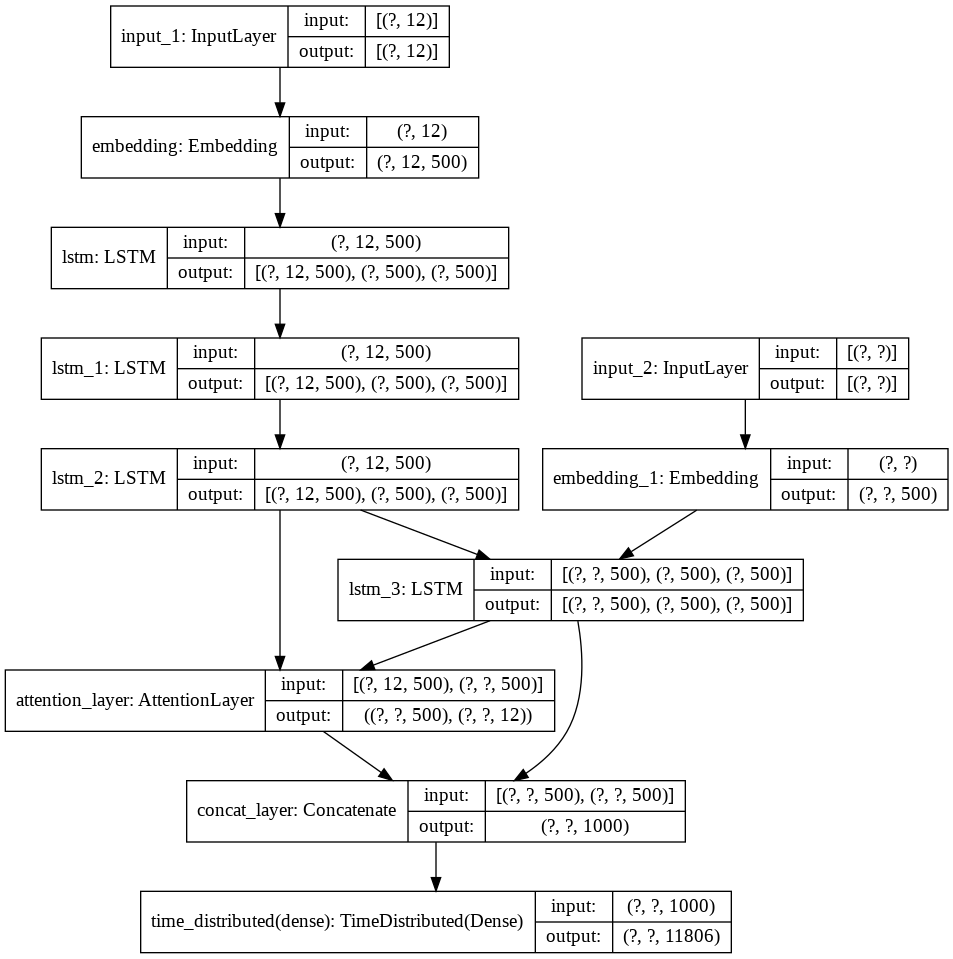

In [35]:
plot_model(model, to_file='train_model.png', show_shapes=True)


#Compile the Model

In [36]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

We are using ‘Teacher Forcing’ technique for faster training of our model. In the teacher forcing method, we also pass the target data as the input to the decoder. For example, if we are going to predict ‘hello’, then we will pass ‘hello’ itself as an input to the decoder. Due to this it makes the learning process faster.

#Fit the Model

In [38]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                    epochs=200, 
                    callbacks=[es],
                    batch_size=512,
                    validation_data = ([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/200
69/69 [==============================] - 32s 463ms/step - loss: 2.8673 - accuracy: 0.6185 - val_loss: 2.2966 - val_accuracy: 0.6714
Epoch 2/200
69/69 [==============================] - 30s 437ms/step - loss: 2.2606 - accuracy: 0.6743 - val_loss: 2.1051 - val_accuracy: 0.6880
Epoch 3/200
69/69 [==============================] - 30s 431ms/step - loss: 2.0359 - accuracy: 0.6924 - val_loss: 1.9094 - val_accuracy: 0.7038
Epoch 4/200
69/69 [==============================] - 30s 438ms/step - loss: 1.8372 - accuracy: 0.7096 - val_loss: 1.8013 - val_accuracy: 0.7139
Epoch 5/200
69/69 [==============================] - 30s 436ms/step - loss: 1.6460 - accuracy: 0.7281 - val_loss: 1.6299 - val_accuracy: 0.7329
Epoch 6/200
69/69 [==============================] - 30s 434ms/step - loss: 1.4705 - accuracy: 0.7450 - val_loss: 1.5597 - val_accuracy: 0.7353
Epoch 7/200
69/69 [==============================] - 30s 434ms/step - loss: 1.3141 - accuracy: 0.7604 - val_loss: 1.4889 - val_accuracy:

#Save model

save our trained model with proper weights

In [49]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [50]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")

#Plot the loss

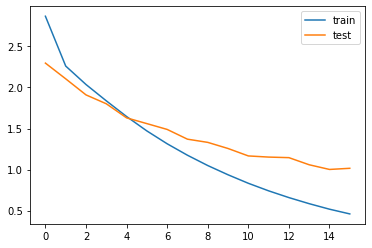

In [51]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

Above is the loss difference in both training and validation phase 

In [52]:
with open('NMT_Etokenizer.pkl','rb') as f:
  vocab_size_source, Eword2index, englishTokenizer = pkl.load(f)

with open('NMT_Mtokenizer.pkl', 'rb') as f:
  vocab_size_target, Mword2index, marathiTokenizer = pkl.load(f)

with open('NMT_data.pkl','rb') as f:
  X_train, y_train, X_test, y_test = pkl.load(f)

Forming reverse Vocabulary

In [53]:
Eindex2word = englishTokenizer.index_word
Mindex2word = marathiTokenizer.index_word

In [54]:
model_loaded.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 12, 500)      2498000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 12, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

#Inference Model

In machine learning we use inference model to predict our output sequences by considering weights from a pre-trained model. In other terms, it can be said that its a model that deduces properties that are learned in training phase and are now used for predicting new sequences.


In [55]:
latent_dim=500
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs

print(encoder_outputs.shape)

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(32,latent_dim))

# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output

print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]

dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

(None, 12, 500)
(None, None)


#Predictions

Now we have trained the sequence to sequence model and created the inference model using the trained model for making a prediction. Let’s predict some Marathi sentences from the English sentences.

In [56]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Mword2index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
          sampled_token = Mindex2word[sampled_token_index]

          if(sampled_token!='end'):
              decoded_sentence += ' '+sampled_token

              # Exit condition: either hit max length or find stop word.
              if (sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1)):
                  stop_condition = True

          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index

          # Update internal states
          e_h, e_c = h, c

    return decoded_sentence

Some transformation before giving a string to the function:

In [57]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Mword2index['start']) and i!=Mword2index['end']):
        newString=newString+Mindex2word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

Call the necessary functions and let’s test our translation model:

In [58]:
for i in range(10):
  
  print("Review:",seq2text(X_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(X_test[i].reshape(1,12)))
  print("\n")

Review: i have one brother 
Original summary: माझा एक भाऊ आहे 
Predicted summary:  माझ्याकडे एक भाऊ आहे


Review: i was drinking milk 
Original summary: मी दूध पित होतो 
Predicted summary:  मी दूध प्यायलो


Review: everyone else is sleeping 
Original summary: बाकी सर्व झोपले आहेत 
Predicted summary:  टॉम सोडून गेला


Review: give me your book 
Original summary: मला तुमचं पुस्तक द्या 
Predicted summary:  तुझं पुस्तक द्या मला


Review: tom lives in another city 
Original summary: टॉम एका दुसर्या शहरात राहतो 
Predicted summary:  टॉम शहरात राहतो


Review: i had a terrible dream 
Original summary: मला एक भयानक स्वप्न पडलेलं 
Predicted summary:  मला एक विचित्र स्वप्न पडलं


Review: i met tom at the airport 
Original summary: मी टॉमला विमानतळावर भेटलो 
Predicted summary:  मी टॉमला आधी भेटले


Review: this isnt what i ordered 
Original summary: मी हे मागवलं नव्हतं 
Predicted summary:  मी तुमचा आवाज मागितलं आहे ते मला कर


Review: its sand 
Original summary: वाळू आहे 
Predicted summary:  ते आहे